In [1]:
import os
import itertools
from collections import defaultdict
from spacy.en import English

In [2]:
os.chdir("..")
os.getcwd()

'/mnt/Storage/Coding_Projects/Candidate_Classifier'

In [3]:
os.getcwd()

'/mnt/Storage/Coding_Projects/Candidate_Classifier'

## Corpora

In [6]:
from candidate_classifier.nltk_model import NgramModel
from candidate_classifier import utils
from nltk.probability import LaplaceProbDist, LidstoneProbDist
from nltk.corpus import PlaintextCorpusReader

SyntaxError: invalid syntax (ngram.py, line 126)

In [4]:
from candidate_classifier.debate_corpus_reader import DebateCorpusReader
from candidate_classifier.string_processing import *

In [5]:
nlp = English(load_vectors=False)

In [6]:
class TransformerWrapper(object):
    def __init__(self, transformer):
        self.transformer = transformer
    
    def tokenize(self, s):
        return self.transformer(s)

class DummyTokenizer(object):
    def tokenize(self, s):
        return s
    
def sent_tokenizer(s):
    doc = nlp(s)
    return [u''.join(t.text_with_ws for t in sent) for sent in doc.sents]


# def word_tokenizer(s):
#     toks = nlp(s)
#     return ['<S>'] + [t.lower_ for t in toks] + ['</S>']

In [10]:
# Replace [*] with ''
# Replace '. . .' with '...'
# Replace multiple ellipses with single ...
# Remove all sentences that end with ...

BRACKET_PATTERN = re.compile(r"\[[a-zA-Z ]*\]", re.U)
SPACED_ELLIPSIS_PATTERN = re.compile(r"((?:\.\s){3})")
MULTI_ELLIPSIS_PATTERN = re.compile(r"(?:(?:\.){3} ?)+")
ELLIPSIS_BRACKET_PATTERN = re.compile(r"(?:(?:\.){3}) *\[[a-zA-Z ]*\] *(?:(?:\.){3} ?)")
ENDS_WITH_ELLIPSIS = lambda s: s[-3:] == '...'
STARTS_WITH_ELLIPSIS = lambda s: s[:3] == '...'
STARTS_WITH_DASH = lambda s: s[0] == '-'
ENDS_WITH_DASH = lambda s: s[-1] == '-'

In [11]:
doc_transformer = TransformerABC(
    prefilter_substitutions=['html entities',
                             'deaccent',
                             'whitespace',
                             (ELLIPSIS_BRACKET_PATTERN, ' '),
                             BRACKET_PATTERN,
                             (SPACED_ELLIPSIS_PATTERN, '...'),
                             (MULTI_ELLIPSIS_PATTERN, '...'),
                             'whitespace',
                             'strip'],
    tokenizer=sent_tokenizer)

sent_filter = TransformerABC(
    prefilter_substitutions=['puntuation', 'strip'],
    filters=[('len', 49)])

In [8]:
dcr = DebateCorpusReader('candidate_classifier/data/raw', '.*\.txt', 
                             sent_tokenizer=TransformerWrapper(doc_transformer), 
                             word_tokenizer=DummyTokenizer())
candidates = ['BUSH', 'CARSON', 'CHRISTIE', 'CRUZ', 'KASICH', 'RUBIO', 'TRUMP', 'CLINTON', 'SANDERS']

NameError: name 'doc_transformer' is not defined

## Preprocess to sentences
I have officially decided that the task is classifying sentences and snippits.  As such, each document will be a sentence.  

#### Precrocessing Steps
- Tokenize to sentences and normalize encoding
- remove all non-ascii characters
- All whitespace to spaces (no newlines)
- Filter all sentences that are less than 50 characters (after removing all punctuation)
- Group all sentences together with their labels and shuffle them
- Write text and labels to (separate) line-delimited files


In [5]:
sents_path = 'candidate_classifier/data/processed/clean_sents.txt'
labels_path = 'candidate_classifier/data/processed/sent_labels.txt'

In [112]:
cleaned_sents = []
for label, sents in dcr.grouped_sents(speakers=candidates).iteritems():
    for sent in sents:
#             stripped = sent.strip(string.punctuation+ ' \n\t')
#             if len(stripped) >= 35:
#                 cleaned_sents.append((label, sent))
        if sent_filter(sent):
            cleaned_sents.append((label, sent))

In [113]:
len(cleaned_sents)

8851

In [114]:
import random
random.shuffle(cleaned_sents)

In [116]:
import codecs

sents_file = codecs.open(sents_path, mode='w', encoding='utf-8')
labels_file = codecs.open(labels_path, mode='w', encoding='utf-8')
    
for sent in cleaned_sents:
    sents_file.write(u'%s\n' % sent[1])
    labels_file.write(u'%s\n' % sent[0])

sents_file.close()
labels_file.close()

## Stats

In [100]:
import pprint
import json
from tabulate import tabulate

In [74]:
def sentence_stats(dcr, filt, speakers=None):
    """
    Returns a dictionary for the given speakers with stats for all sentences
    dcr is a DebateCorpusReader
    filt is a callable that will turn sentences we want to filter into a falsy value
    """
    if speakers is None:
        speakers = dcr.speakers()
    stats = {s:dict() for s in speakers}
    
    for speaker, sents in dcr.grouped_sents(speakers=speakers).iteritems():
        stats[speaker]['count'] = len(sents)
        lengths = [len(s) for s in sents]
        mean_length = np.mean(lengths)
        std = np.std(lengths)
        stats[speaker]['length'] = '%0.2f (+/- %0.2f)' % (mean_length, std*1.960)
    
    return stats
    

In [110]:
sent_stats = sentence_stats(dcr, sent_filter)

In [109]:
# NB: This is actually a poisson distribution, so I should be reporting it a bit differently than 
# the +-
for tup in sorted(sent_stats.iteritems(), key=lambda tup: tup[1]['count'], reverse=True):
#     print "%s\t\t\tcount: %s\tlength: %s" % (tup[0], tup[1]['count'], tup[1]['length'])
    print "{: <20} {: <10} {: <20}".format(tup[0], tup[1]['count'], tup[1]['length'])

TRUMP                2647       57.55 (+/- 91.10)   
SANDERS              1948       90.94 (+/- 144.33)  
CLINTON              1867       102.53 (+/- 147.05) 
RUBIO                1833       87.63 (+/- 119.96)  
CRUZ                 1504       90.61 (+/- 131.77)  
KASICH               1410       80.09 (+/- 124.65)  
BUSH                 1374       78.07 (+/- 115.14)  
CHRISTIE             961        86.49 (+/- 126.81)  
CARSON               907        88.96 (+/- 122.32)  
PAUL                 704        76.77 (+/- 100.19)  
FIORINA              546        80.49 (+/- 120.56)  
MUIR                 510        71.71 (+/- 124.24)  
DICKERSON            485        73.13 (+/- 116.95)  
BLITZER              456        50.85 (+/- 92.77)   
TAPPER               429        56.00 (+/- 95.77)   
COOPER               427        68.51 (+/- 114.06)  
RADDATZ              321        78.61 (+/- 118.99)  
HUCKABEE             270        87.93 (+/- 128.88)  
KELLY                246        70.84 (+/- 120

## Classifier

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import numpy as np
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, classification_report, f1_score
import codecs
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
def docs():
    with codecs.open(sents_path, mode='r', encoding='utf-8') as _f:
        for line in _f:
            yield line

def labels():
    with codecs.open(labels_path, mode='r', encoding='utf-8') as _f:
        for line in _f:
            yield line.strip()
labels_list = list(labels())
candidates = sorted(list(set(labels_list)))
docs_list = list(docs())
print candidates

[u'BUSH', u'CARSON', u'CHRISTIE', u'CLINTON', u'CRUZ', u'KASICH', u'RUBIO', u'SANDERS', u'TRUMP']


In [8]:
def get_scores(clf, X, y):
    scores = cross_val_score(clf, X, y, cv=10, scoring='f1_samples')
    print scores
    print "\n"
    # Use 1.96 * std b/c 95% of the data should lie in that range, 
    # which means this represents a 95% confidence interval
    print "F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 1.960)

In [9]:
def fancy_scorer(y, y_pred, **kwargs):
    # Print classification report
    print classification_report(y, y_pred, target_names=candidates)
    return f1_score(y, y_pred, labels=candidates, average='weighted')    

def f1_weighted_scorer(y, y_pred, **kwargs):
    return f1_score(y, y_pred, labels=candidates, average='weighted')

# Grid Searches

In [12]:
simple_cleaner = TransformerABC(prefilter_substitutions=['strip', 'lower'])

### Tokenizers

In [13]:
def merge_np(doc):
    for np in doc.noun_chunks:
        while len(np) > 1 and np[0].dep_ not in ('avmod', 'amod', 'compound'):
            np = np[1:]
        np.merge(np.root.tag_, np.text, np.root.ent_type_)
    return doc

def merge_ent(doc):
    for ent in doc.ents:
        # In the sense2vec code they do something a bit different with the entity label and I'm not sure why
        ent.merge(ent.root.tag_, ent.text, ent.label_)
    return doc

def filter_features(toks, attrs):
    return [t for t in toks if not any([getattr(t, a) for a in attrs])]
    

In [14]:
from collections import deque
import copy
import operator

In [15]:
# Get paths that cross head-nodes


def sn_grams(sent, m, n, prop='lemma_', spanning=False):
    """Get all syntactic ngrams from min length m to max length n"""
    if spanning:
        root = sent.root
        return sn_spanning_helper([], deque([], n), root, m, prop=prop)
    else:
        root = sent.root
        return sn_helper([], deque([], n), root, m, prop=prop)

def sn_helper(acc, buff, curr, m, prop='lemma_'):
    # Add curr
    # But don't add ROOT because those relations occur in almost all sentences
    # NB: No need to pop b/c deque has max length specified
    if prop == 'dep_' and curr.dep_ == 'ROOT':
        pass
    else:
        buff.appendleft(getattr(curr, prop))
    
    # Create the ngrams that end with the current node
    # Having the n-grams in reverse lexical order is a bit odd 
    # for humans to read, but because it's deterministic, it 
    # shouldn't make any difference to the computer for using them as 
    # features
#     gram = []
#     if len(buff) >= m:
#         for i, tok in enumerate(buff):
#             # Build up the ngram
#             gram.append(tok)
#             # Only append ngrams >= the min length
#             if len(gram) >= m:
#                 acc.append('_'.join(reversed(gram)))
    
    # Optimized
    gram = ''
    count = 0
    if len(buff) >= m:
        for i, tok in enumerate(buff):
            # Build up the ngram
            gram += '_' + tok
            count += 1
            # Only append ngrams >= the min length
            if count >= m:
                acc.append(gram)
    
    # Add all childrens' ngrams
    for c in curr.children:
        # Add to acc with destructive modification 
        # but don't let children modify buffer because it needs 
        # to be in the same state for the next child of curr
        sn_helper(acc, copy.copy(buff), c, m, prop=prop)
    
    # Return the accumulator
    return acc
        

# TODO:re-write as iterative
# TODO: I'm pretty sure this is a dynamic programming problem
# TODO: skip POBJ?
def sn_spanning_helper(acc, buff, curr, m, prop='lemma_'):
#     print 'curr:', (getattr(curr, prop))
    # Add curr
    # But don't add ROOT because those relations occur in almost all sentences
    # NB: No need to pop b/c deque has max length specified
    if prop == 'dep_' and curr.dep_ == 'ROOT':
        pass
    else:
        buff.append(curr)
        buff = deque(sorted(buff, key=operator.attrgetter('idx')), buff.maxlen)
        
    # Create the ngrams that end with the current node
    # Having the n-grams in reverse lexical order is a bit odd 
    # for humans to read, but because it's deterministic, it 
    # shouldn't make any difference to the computer for using them as 
    # features
    gram = []
    if len(buff) >= m:
        for i, tok in enumerate(buff):
            # Build up the ngram
#             gram.append(tok)
            gram.append(getattr(tok, prop))
            # Only append ngrams >= the min length
            if len(gram) >= m:
                acc.append('_'.join(gram))
    
    if curr.n_lefts > 0:
        # Add all left ngrams
        for c in curr.lefts:
            # Don't revisit self
            if c is curr:
                continue
            # Add to acc with destructive modification 
            # but don't let children modify buffer because it needs 
            # to be in the same state for the next child of curr
            sn_spanning_helper(acc, copy.copy(buff), c, m, prop=prop)
    else:
        # Add all right ngrams
        for c in curr.rights:
            # Add to acc with destructive modification 
            # but don't let children modify buffer because it needs 
            # to be in the same state for the next child of curr
            sn_spanning_helper(acc, copy.copy(buff), c, m, prop=prop)

    # Now, decend the parent's rights
    # So long as this isn't the root
    if curr.head is curr:
        return acc
    else:
        for c in curr.head.rights:
            # Don't revisit self
            if c is curr:
                continue
            sn_spanning_helper(acc, copy.copy(buff), c, m, prop=prop)
    
    # Return the accumulator
    return acc

In [16]:
def get_sn_grams(doc, prop, spanning=False):
    result = []
    for sent in doc.sents:
        result.extend(sn_grams(sent, 1, 3, prop=prop, spanning=spanning))
    return result

def sn_tokenizer(s):
    return get_sn_grams(nlp(s), 'lemma_')

def sn_pos_tokenizer(s):
    return get_sn_grams(nlp(s), 'tag_')

def sn_merge_ents(s):
    doc = merge_ent(nlp(s))
    return get_sn_grams(doc, 'lemma_')

def sn_pos_merge_ent(s):
    doc = merge_ent(nlp(s))
    return get_sn_grams(doc, 'tag_')

def sn_merge_np(s):
    doc = merge_np(nlp(s))
    return get_sn_grams(doc, 'lemma_')

def sn_sr_tokenizer(s):
    return get_sn_grams(nlp(s), 'dep_')

def sn_sr_merge_ent(s):
    doc = merge_ent(nlp(s))
    return get_sn_grams(nlp(s), 'dep_')

def sn_spanning_tokenizer(s):
    return get_sn_grams(nlp(s), 'lemma_', spanning=True)
    
def sn_spanning_merge_ents(s):
    doc = merge_ent(nlp(s))
    return get_sn_grams(nlp(s), 'lemma_', spanning=True)

In [17]:
def simple_tokenizer(s):
    return s.split()

def lemmas_tokenizer(s):
    return [t.lemma_ for t in nlp(s) if not t.is_space]

def lemmas_no_punct(s):
    return [t.lemma_ for t in nlp(s) if not any([t.is_punct, t.is_space])]

def lemmas_no_punt_no_num(s):
    return [t.lemma_ for t in nlp(s) if not any([t.is_punct, t.is_space, t.is_digit, t.is_like_num])]

def lemmas_sub_nums(s):
    pass

def lemmas_no_punct_sub_nums(s):
    pass

# Spacy tokenization, no lemmatization
# replace candidate and person names with PERSON

In [53]:
def lemmas_merge_np(s):
    toks = merge_np(nlp(s))
    return [t.lemma_ for t in toks if not t.is_space]

def lemmas_merge_ents(s):
    toks = merge_ent(nlp(s))
    return [t.lemma_ for t in toks if not t.is_space]

def lemmas_merge_np_merge_ents(s):
    toks = merge_ent(nlp(s))
    toks = merge_np(toks)
    return [t.lemma_ for t in toks if not t.is_space]


In [54]:
def lemmas_cased_tokenizer(s):
    """Tokenizer that lematizes but preserves the case of the first letter of tokens"""
    toks = nlp(s)
    return [t.lemma_.title() if t.is_title else t.lemma_ for t in toks]

def lemmas_cased_merge_ents(s):
    toks = merge_ent(nlp(s))
    return [t.lemma_.title() if t.is_title else t.lemma_ for t in toks]

In [19]:
# So these were basically useless.  I'm pretty sure I'm using them wrong...

def get_brown(doc):
    out = []
    for t in doc:
        if not t.is_space:
            # Should use tok.ent_iob_
            if t.cluster != 0 and t.tag_ != 'NNP':
                out.append("**%s**" % t.cluster)
            else:
                out.append(t.lemma_)
    return out

def brown_cluster_tokenizer(s):
    toks = nlp(s)
    return get_brown(toks)
    

def brown_cluster_merge_ents(s):
    toks = merge_ent(nlp(s))
    return get_brown(toks)

### Stopwords Sets

In [26]:
sk_stops = ENGLISH_STOP_WORDS

### Pipelines

In [20]:
mnb_pipe = Pipeline([
        ('vect', CountVectorizer(preprocessor=simple_cleaner, token_pattern=r".*")),
        ('clf', MultinomialNB())
])

sgd_pipe = Pipeline([
        ('vect', CountVectorizer(preprocessor=simple_cleaner, token_pattern=r".*")),
        ('clf', SGDClassifier())
])

rf_pipe = Pipeline([
        ('vect', CountVectorizer(preprocessor=simple_cleaner, token_pattern=r".*")),
        ('clf', RandomForestClassifier())
])

svm_pipe = Pipeline([
        ('vect', CountVectorizer(preprocessor=simple_cleaner, token_pattern=r".*")),
        ('clf', LinearSVC())
])

# TODO:
# - TFIDF
# - log-count ratio?
# - binarize
# Chi-squared?

pipes = [mnb_pipe, sgd_pipe, rf_pipe, svm_pipe]

### Grids

In [21]:
mnb_grid_params = {
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (simple_tokenizer, lemmas_tokenizer, lemmas_no_punct),
    'clf__alpha': (0.001, 0.01, 0.1, 1)
}

mnb_tokenization_grid_params = {
    'vect__ngram_range': ((1,1),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (simple_tokenizer,
                        lemmas_tokenizer, 
                        lemmas_no_punct,
                        lemmas_merge_np,
                        lemmas_merge_ents,
                        lemmas_merge_np_merge_ents
                       ),
    'clf__alpha': (0.075, 0.1)
}

mnb_brown_grid_params = {
    'vect__ngram_range': ((1,1),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (lemmas_tokenizer, 
                        lemmas_no_punct,
                        lemmas_merge_ents,
                        brown_cluster_tokenizer,
                        brown_cluster_merge_ents
                       ),
    'clf__alpha': (0.075, 0.1)
}


mnb_sn_grid_params = {
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (sn_tokenizer,
                        sn_pos_tokenizer,
                        sn_merge_ents,
                        sn_pos_merge_ent,
                        sn_merge_np,
                        sn_sr_tokenizer,
                        sn_sr_merge_ent,
                        sn_spanning_tokenizer,
                        sn_spanning_merge_ents
                       ),
    'clf__alpha': (0.075, 0.1)
}


# This is really too many parameters
# Apparently l2 loss is depricated and I should use squared_hinge
sgd_grid_params = {
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (lemmas_tokenizer, lemmas_no_punct),
    'clf__loss': ('hinge', 'log', 'perceptron'),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__alpha': (0.0001, 0.00001, 0.000001),
    'clf__l1_ratio': (0.15, 0.05, 0.005),
    'clf__fit_intercept': (True, False),
    'clf__n_iter': (10, 50, 85)
}


rf_grid_params = {
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (simple_tokenizer, 
                        lemmas_tokenizer, 
                        lemmas_no_punct,
                        lemmas_merge_np,
                        lemmas_merge_ents,
                        lemmas_merge_np_merge_ents
                       ),
    'clf__n_estimators': (10, 25),
    'clf__criterion': ('gini', 'entropy'),
    'clf__max_features': ('auto', None),
    'clf__class_weight': (None, 'balanced')
}

svm_grid_params = {
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (simple_tokenizer, lemmas_tokenizer, lemmas_no_punct),
    'clf__C': (0.01, 0.1, 1, 10)#,
#     'clf__max_iter': (1000, 2000)
}

svm_tokenization_grid_params = {
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (simple_tokenizer,
                        lemmas_tokenizer, 
                        lemmas_no_punct,
                        lemmas_merge_np,
                        lemmas_merge_ents,
                        lemmas_merge_np_merge_ents
                       ),
    'clf__C': (0.01, 0.025, 0.05, 0.075)#,
#     'clf__max_iter': (1000, 2000)
}

svm_sn_grid_params = {
    'vect__stop_words': ('english', None),
    'vect__tokenizer': (sn_tokenizer,
                        sn_pos_tokenizer,
                        sn_merge_ents,
                        sn_pos_merge_ent,
                        sn_merge_np
                       ),
    'clf__C': (0.04, 0.05)
}


In [22]:
from pprint import pprint
from time import time
import logging

In [23]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
fmt = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hndlr = logging.StreamHandler()
hndlr.setFormatter(fmt)
logger.addHandler(hndlr)

In [24]:
def process_grid(pipe, params, data, labels):
    grid_search = GridSearchCV(pipe, params, n_jobs=-1, scoring=make_scorer(f1_weighted_scorer), cv=3, verbose=1)
    
    print "Performing grid search..."
    print "pipeline:", [name for name, _ in pipe.steps]
    print "parameters:"
    pprint(params)
    
    t0 = time()
    grid_search.fit(data, labels)
    
    print "done in %0.3fs" % (time() - t0)
    print ''
    
    print "Best score: %0.3f" % grid_search.best_score_
    print "Best parameters set:"
    
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print "\t%s: %r" % (param_name, best_parameters[param_name])
    
    return grid_search

# Results

Except for the random forest, these are all linear classifiers of one form or another (I'm pretty sure that NB is linear for this case though I'd have to check) and they're all trying to find the best separating hyperplane in their own way.  As such, now that I've had a chance to play with the different models and see some of their perameters, I'm going to spend the rest of my time focusing on tokeniztion and feature transformations (tf-idf, etc.) using only MNB and LinearSVC using some of the hyperparameters I've found with these experiments.  I think that that is likely to give me the most bang for my buck as it were.

### Try not nowercasing when using spacy tokenization

### Findings:
- Either brown clusters are really useless or I'm using them wrong
- Merging entities consistently performs a tiny bit better than just lemmatization while merging noun chunks performs significantly worse.  
    - I believe that this is most likely a quirk of the dataset
- sn-grams (as described in the paper that I'll cite here are some point) perform consistently worse than just using ngrams
- Still need to try spanning sngrams
- For mnb, removing any tokens at all, even punctuation, hurts performance.  I'm not sure if that's a quirk of this data set or not though.

##### Notes
- It would be nice to have some way to visualize the outcomes of all of the classifiers tried in the grid searches but there are so many that it would be difficult
  - I think a simple 2d list plot would actually work pretty well, as something like that should look like a kind of step function based on which parameter has changed each time.  The only thing is that it would be nice to get those steps highlighted or somthign so that I could say, I want to compare the outcomes of all classifiers that used this tokenizer, or somethign like that. I might be able to do that by just filtering the list tho. 

In [90]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [82]:
# Get the best config from each tokenizer
tokenizers = mnb_tokenization_grid_params['vect__tokenizer']

def t_filter(t):
    def inner(score_tup):
        return score_tup.parameters['vect__tokenizer'] == t
    return inner

def get_tokenizer_best(grid, tokenizers):
    best = {}
    
    for tokenizer in tokenizers:
        scores = filter(t_filter(tokenizer), grid.grid_scores_)
        t_best = max(scores, key=lambda s: s.mean_validation_score)
        best[tokenizer.func_name] = t_best.mean_validation_score
    return best
    

In [84]:
# Is merging entities really doing anything?
# Yes, but not actually all that much
def get_vocab_sizes(params):
    for t in params['vect__tokenizer']:
        c = CountVectorizer(preprocessor=simple_cleaner,
                             ngram_range=(1,3),
                             tokenizer=t)
        print t.func_name, len(c.fit(docs_list).vocabulary_)


## LinearSVC

In [88]:
svm_grid = process_grid(svm_pipe, svm_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.01, 0.1, 1, 10),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function simple_tokenizer at 0x7f5254df6848>,
                     <function lemmas_tokenizer at 0x7f52783ee848>,
                     <function lemmas_no_punct_tokenizer at 0x7f5254e21b18>)}
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.9min finished


done in 429.823s

Best score: 0.579
Best parameters set:
	clf__C: 0.1
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_tokenizer at 0x7f52783ee848>


In [102]:
svm_tokenization_grid = process_grid(svm_pipe, svm_tokenization_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.01, 0.025, 0.05, 0.075),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function simple_tokenizer at 0x7f8d7a1b1b18>,
                     <function lemmas_tokenizer at 0x7f8d7a1b1cf8>,
                     <function lemmas_no_punct at 0x7f8d7a1b1e60>,
                     <function lemmas_merge_np at 0x7f8d7a1b1de8>,
                     <function lemmas_merge_ents at 0x7f8d7a1b1f50>,
                     <function lemmas_merge_np_merge_ents at 0x7f8de64c5de8>)}
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 16.7min finished


done in 1018.557s

Best score: 0.583
Best parameters set:
	clf__C: 0.05
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_tokenizer at 0x7f8d7a1b1cf8>


In [171]:
svm_sn_grid = process_grid(svm_pipe, svm_sn_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.04, 0.05),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function sn_tokenizer at 0x7f8de6409e60>,
                     <function sn_pos_tokenizer at 0x7f8dd0fd1cf8>,
                     <function sn_merge_ents at 0x7f8dd0fd11b8>,
                     <function sn_pos_merge_ent at 0x7f8da38ff320>,
                     <function sn_merge_np at 0x7f8da38ff410>)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


done in 305.002s

Best score: 0.567
Best parameters set:
	clf__C: 0.04
	vect__stop_words: None
	vect__tokenizer: <function sn_merge_ents at 0x7f8dd0fd11b8>


## MNB 

### MNB Basic

The most influential parameter (by far) is the alpha parameter for smoothing.
The next most influential feature was the addition of n-grams, which made a big difference and also, using any kind of stopwords, even removing punctuation, seemed to have a very negative result on the outcomes.

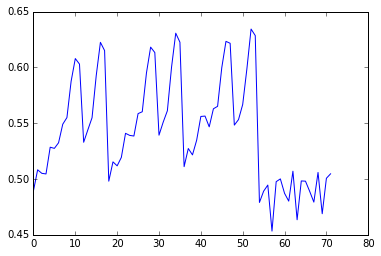

In [101]:
plt.plot([clf.mean_validation_score for clf in mnb_grid.grid_scores_])
plt.show()

In [53]:
mnb_grid = process_grid(mnb_pipe, mnb_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.001, 0.01, 0.1, 1),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function simple_tokenizer at 0x7f5254a35b90>,
                     <function lemmas_tokenizer at 0x7f5254a35f50>,
                     <function lemmas_no_punct_tokenizer at 0x7f5254a35ed8>)}
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  5.5min finished


done in 343.143s

Best score: 0.634
Best parameters set:
	clf__alpha: 0.1
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_tokenizer at 0x7f5254a35f50>


### MNB Tokenization Tests

In [124]:
len(mnb_grid.best_estimator_.steps[0][1].vocabulary_)

187355

In [123]:
len(mnb_tokenization_grid.best_estimator_.steps[0][1].vocabulary_)

185133

In [37]:
mnb_tokenization_grid = process_grid(mnb_pipe, mnb_tokenization_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.075, 0.1),
 'vect__ngram_range': ((1, 1), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function simple_tokenizer at 0x7f8da394caa0>,
                     <function lemmas_tokenizer at 0x7f8da394c488>,
                     <function lemmas_no_punct at 0x7f8da394c6e0>,
                     <function lemmas_merge_np at 0x7f8da394ccf8>,
                     <function lemmas_merge_ents at 0x7f8da394cd70>,
                     <function lemmas_merge_np_merge_ents at 0x7f8da394c578>)}
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.7min finished


done in 354.367s

Best score: 0.638
Best parameters set:
	clf__alpha: 0.075
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_merge_ents at 0x7f8da394cd70>


In [90]:
get_tokenizer_best(mnb_tokenization_grid, mnb_tokenization_grid_params['vect__tokenizer'])

ValueError: max() arg is an empty sequence

In [85]:
get_vocab_sizes(mnb_tokenization_grid_params)

simple_tokenizer 214228
lemmas_tokenizer 185133
lemmas_no_punct 178210
lemmas_merge_np 189509
lemmas_merge_ents 185636
lemmas_merge_np_merge_ents 189598


In [80]:
mnb_brown_grid = process_grid(mnb_pipe, mnb_brown_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.075, 0.1),
 'vect__ngram_range': ((1, 1), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function lemmas_tokenizer at 0x7f8dd24bb5f0>,
                     <function lemmas_no_punct at 0x7f8dd24bb578>,
                     <function lemmas_merge_ents at 0x7f8dd24bb848>,
                     <function brown_cluster_tokenizer at 0x7f8dd24bbaa0>,
                     <function brown_cluster_merge_ents at 0x7f8dd2697a28>)}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:107

done in 335.288s

Best score: 0.638
Best parameters set:
	clf__alpha: 0.075
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_merge_ents at 0x7f8dd24bb848>


In [83]:
get_tokenizer_best(mnb_brown_grid, mnb_brown_grid_params['vect__tokenizer'])

{'brown_cluster_merge_ents': 0.040426216670964576,
 'brown_cluster_tokenizer': 0.040426216670964576,
 'lemmas_merge_ents': 0.63754580351976431,
 'lemmas_no_punct': 0.62979803124252964,
 'lemmas_tokenizer': 0.63706663132351105}

In [86]:
get_vocab_sizes(mnb_brown_grid_params)

lemmas_tokenizer 185133
lemmas_no_punct 178210
lemmas_merge_ents 185636
brown_cluster_tokenizer 141
brown_cluster_merge_ents 141


In [43]:
mnb_sn_grid = process_grid(mnb_pipe, mnb_sn_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.075, 0.1),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function sn_tokenizer at 0x7f47844378c0>,
                     <function sn_pos_tokenizer at 0x7f47e7ed1de8>,
                     <function sn_merge_ents at 0x7f47e7ed1668>,
                     <function sn_pos_merge_ent at 0x7f47e7ed1500>,
                     <function sn_merge_np at 0x7f47e7ed1aa0>,
                     <function sn_sr_tokenizer at 0x7f47e7ed1758>,
                     <function sn_sr_merge_ent at 0x7f47e7ed17d0>,
                     <function sn_spanning_tokenizer at 0x7f47e7ed1848>,
                     <function sn_spanning_merge_ents at 0x7f478440b050>)}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [180]:
get_tokenizer_best(mnb_sn_grid, mnb_sn_grid_params['vect__tokenizer'])

{'sn_merge_ents': 0.59700803649875622,
 'sn_merge_np': 0.56911889361623114,
 'sn_pos_merge_ent': 0.23784061873661111,
 'sn_pos_tokenizer': 0.23871240797297844,
 'sn_sr_merge_ent': 0.21003203607692364,
 'sn_sr_tokenizer': 0.21003203607692364,
 'sn_tokenizer': 0.59366724307787844}

In [165]:
get_tokenizer_best(mnb_sn_grid, mnb_sn_grid_params['vect__tokenizer'])

{'sn_merge_ents': 0.59700803649875622,
 'sn_merge_np': 0.56911889361623114,
 'sn_pos_merge_ent': 0.23784061873661111,
 'sn_pos_tokenizer': 0.23871240797297844,
 'sn_tokenizer': 0.59366724307787844}

### Random Forest

In [98]:
rf_grid = process_grid(rf_pipe, rf_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__class_weight': (None, 'balanced'),
 'clf__criterion': ('gini', 'entropy'),
 'clf__max_features': ('auto', None),
 'clf__n_estimators': (10, 25),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function simple_tokenizer at 0x7f8d7a1b1b18>,
                     <function lemmas_tokenizer at 0x7f8d7a1b1cf8>,
                     <function lemmas_no_punct at 0x7f8d7a1b1e60>,
                     <function lemmas_merge_np at 0x7f8d7a1b1de8>,
                     <function lemmas_merge_ents at 0x7f8d7a1b1f50>,
                     <function lemmas_merge_np_merge_ents at 0x7f8de64c5de8>)}
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 62.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 95.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 164.7min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 262.6min finished


done in 15776.134s

Best score: 0.400
Best parameters set:
	clf__class_weight: None
	clf__criterion: 'gini'
	clf__max_features: 'auto'
	clf__n_estimators: 25
	vect__ngram_range: (1, 2)
	vect__stop_words: 'english'
	vect__tokenizer: <function lemmas_no_punct at 0x7f8d7a1b1e60>


### SGD

In [74]:
sgd_grid = process_grid(sgd_pipe, sgd_grid_params, docs_list, labels_list)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.0001, 1e-05, 1e-06),
 'clf__fit_intercept': (True, False),
 'clf__l1_ratio': (0.15, 0.05, 0.005),
 'clf__loss': ('hinge', 'log', 'perceptron'),
 'clf__n_iter': (10, 50, 85),
 'clf__penalty': ('l1', 'l2', 'elasticnet'),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
 'vect__stop_words': ('english', None),
 'vect__tokenizer': (<function lemmas_tokenizer at 0x7f52783ee848>,
                     <function lemmas_no_punct_tokenizer at 0x7f5254e21b18>)}
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 69.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 94.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 123.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 155.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 192.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 232.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 276.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 324.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 376.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 431.7min
[Parallel(n_jobs=-1)]: Done 12784 tasks      | ela

done in 40381.515s

Best score: 0.579
Best parameters set:
	clf__alpha: 0.0001
	clf__fit_intercept: False
	clf__l1_ratio: 0.05
	clf__loss: 'hinge'
	clf__n_iter: 85
	clf__penalty: 'l2'
	vect__ngram_range: (1, 3)
	vect__stop_words: None
	vect__tokenizer: <function lemmas_no_punct_tokenizer at 0x7f5254e21b18>


## NGram Model
This definitely isn't a BOW model, but everything is already loaded in this notebook so I wanted to test this here

#### Findings:
- Lemmas_merge_ents performed best, beating the basic lemmas_tokenizer by a slim margin exactly as it did got MNB.  I expected the lemmas_cased_merge_ents tokenizer to actually do better but nothing beats lemmas I guess.
    - I'd like to try this again with some other data, but on this dataset it looks like lemmas plust merging entities wins again.


#### Ideas:
- Try without lowercase?
    - The performance of the parser may be effected by casing so it might be better not to lowercase before tokenizing when using spacy
- Try a lematizing tokenizer that resores original cases to words

In [10]:
from candidate_classifier.nltk_model.ngram_classifier import NgramClassifier
from sklearn.multiclass import OneVsOneClassifier
from candidate_classifier.tokenizers import *

In [11]:
ng_tokenizers = [TransformerABC(prefilter_substitutions=['strip'], 
                                tokenizer=t) for t in 
                 (simple_tokenizer,
                  lemmas_tokenizer, 
                  lemmas_no_punct,
                  lemmas_merge_np,
                  lemmas_merge_ents,
                  lemmas_merge_np_merge_ents,
                  lemmas_cased_tokenizer,
                  lemmas_cased_merge_ents
                 )]

In [12]:
ng_data = [list(t(docs_list)) for t in ng_tokenizers]

In [13]:
ngram_pipe = Pipeline([
        ('clf', OneVsOneClassifier(NgramClassifier(pad_ngrams=True)))
])

In [35]:
# Simple Tokenizer
cross_val_score(ngram_pipe, np.asarray(ng_data[0]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.51408072,  0.50890405,  0.51399413])

In [36]:
# Lemmas Tokenizer
# 0.60172715
cross_val_score(ngram_pipe, np.asarray(ng_data[1]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.60340864,  0.59280579,  0.60896702])

In [43]:
# Lemmas no punct
# 0.5433941399999999
cross_val_score(ngram_pipe, np.asarray(ng_data[2]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.55570972,  0.53112549,  0.54334721])

In [44]:
# Lemmas merge np
# 0.5718811033333334
cross_val_score(ngram_pipe, np.asarray(ng_data[3]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.57854247,  0.56107062,  0.57603022])

In [40]:
# Lemmas merge entities
# 0.6033878333333333
cross_val_score(ngram_pipe, np.asarray(ng_data[4]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.60297723,  0.59464603,  0.61254024])

In [47]:
# Lemmas merge np and ents
# 0.5718806833333333
cross_val_score(ngram_pipe, np.asarray(ng_data[5]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.57993891,  0.56202543,  0.57367771])

In [60]:
# Lemmas cased
# 0.59643039
cross_val_score(ngram_pipe, np.asarray(ng_data[6]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.5987464 ,  0.58936852,  0.60117625])

In [61]:
# Lemmas Cased Merge Ents
# 0.5961278933333333
cross_val_score(ngram_pipe, np.asarray(ng_data[7]), y=labels_list, cv=3, scoring='f1_weighted')

array([ 0.60078256,  0.58637938,  0.60122174])

In [14]:
# I have no idea what happened, I tried everything, even check out the old git version and nothing gets back 
# to that 60% f1 score.  :<
# Lemmas merge entities
scores = cross_val_score(ngram_pipe, np.asarray(ng_data[4]), y=labels_list, cv=3, scoring='f1_weighted')
print scores
print np.mean(scores)

[ 0.57520839  0.56867061  0.58508877]
0.576322588505


## Scratch

In [51]:
txt = u"What do you think Donald Trump has to say about that? Listening to this, do you think this is the tone — this immigration debate that republicans need to take to win back Hispanics into our party especially states like where we are in Nevada that has a pretty Hispanic community?"

In [59]:
toks = nlp(txt)
'  '.join("%s|%s|%s|%s" % (tok.cluster, tok.tag_, tok.text) for tok in toks)

u'702|WP|What  2042|VBP|do  602|PRP|you  1674|VB|think  502|NNP|Donald  22|NNP|Trump  890|VBZ|has  12|TO|to  1162|VB|say  618|IN|about  84|DT|that  0|.|?  510|VBG|Listening  12|IN|to  63|DT|this  4|,|,  2042|VBP|do  602|PRP|you  1674|VB|think  63|DT|this  762|VBZ|is  11|DT|the  2757|NN|tone  0|:|\u2014  63|DT|this  55|NN|immigration  1733|NN|debate  84|WDT|that  0|VBZ|republicans  2954|VBP|need  12|TO|to  6666|VB|take  12|TO|to  1290|VB|win  7530|RP|back  1901|NNPS|Hispanics  8188|IN|into  59|PRP$|our  809|NN|party  27882|RB|especially  845|VBZ|states  1684|IN|like  8148|WRB|where  1626|PRP|we  1530|VBP|are  60|IN|in  166|NNP|Nevada  84|WDT|that  890|VBZ|has  19|DT|a  234|RB|pretty  215|JJ|Hispanic  1829|NN|community  0|.|?'

In [52]:
toks = nlp(txt)
for ent in toks.ents:
    ent.merge(ent.root.tag_, ent.text, ent.label_)
'  '.join("%s|%s|%s" % (tok.lemma_, tok.is_title, tok.text) for tok in toks)

u'what|True|What  do|False|do  you|False|you  think|False|think  Donald Trump|True|Donald Trump  have|False|has  to|False|to  say|False|say  about|False|about  that|False|that  ?|False|?  listen|True|Listening  to|False|to  this|False|this  ,|False|,  do|False|do  you|False|you  think|False|think  this|False|this  be|False|is  the|False|the  tone|False|tone  --|False|\u2014  this|False|this  immigration|False|immigration  debate|False|debate  that|False|that  republicans|False|republicans  need|False|need  to|False|to  take|False|take  to|False|to  win|False|win  back|False|back  Hispanics|True|Hispanics  into|False|into  our|False|our  party|False|party  especially|False|especially  state|False|states  like|False|like  where|False|where  we|False|we  be|False|are  in|False|in  Nevada|True|Nevada  that|False|that  have|False|has  a|False|a  pretty|False|pretty  Hispanic|True|Hispanic  community|False|community  ?|False|?'

In [65]:
for sent in nlp(txt).sents:
    print type(sent)
    

<type 'spacy.tokens.span.Span'>
<type 'spacy.tokens.span.Span'>


In [153]:
tokens = nlp(u'Mr. Best flew to New York on Saturday morning.')
ents = list(tokens.ents)
ents

[Best, New York, Saturday morning]

In [42]:
txt = u"We're closing too many hospitals."
' '.join(tok.lemma_ for tok in nlp(txt))

u"we 're close too many hospital ."

In [139]:
txt = u"Economic news has little effect on financial markets"
for s in nlp(txt).sents:
    for c in s.root.children:
        print c.orth_
        
        

news
effect


In [49]:
txt = u"Economic news has little effect on financial markets"
print '  '.join("%s|%s" % (tok.is_title, tok.text) for tok in nlp(txt))
print [tok.dep_ == 'ROOT' for tok in nlp(txt)]

True|Economic  False|news  False|has  False|little  False|effect  False|on  False|financial  False|markets
[False, False, True, False, False, False, False, False]


### Syntactic Ngrams
ngrams based on the neighbors in the dependency tree

In [246]:
# Get paths that cross head-nodes


def sn_grams(sent, m, n, prop='lemma_', spanning=False):
    """Get all syntactic ngrams from min length m to max length n"""
    root = sent.root
    if spanning:
        return sn_spanning_helper([], deque([], n), root, m, prop=prop)
    else:
        return sn_helper([], deque([], n), root, m, prop=prop)

def sn_helper(acc, buff, curr, m, prop='lemma_'):
    # Add curr
    # But don't add ROOT because those relations occur in almost all sentences
    # NB: No need to pop b/c deque has max length specified
    if prop == 'dep_' and curr.dep_ == 'ROOT':
        pass
    else:
        buff.appendleft(getattr(curr, prop))
    
    # Create the ngrams that end with the current node
    # Having the n-grams in reverse lexical order is a bit odd 
    # for humans to read, but because it's deterministic, it 
    # shouldn't make any difference to the computer for using them as 
    # features
    gram = []
    if len(buff) >= m:
        for i, tok in enumerate(buff):
            # Build up the ngram
            gram.append(tok)
            # Only append ngrams >= the min length
            if len(gram) >= m:
                acc.append('_'.join(reversed(gram)))
    
    # Optimized
#     gram = ''
#     count = 0
#     if len(buff) >= m:
#         for i, tok in enumerate(buff):
#             # Build up the ngram
#             gram += '_' + tok
#             count += 1
#             # Only append ngrams >= the min length
#             if count >= m:
#                 acc.append(gram)
    
    # Add all childrens' ngrams
    for c in curr.children:
        # Add to acc with destructive modification 
        # but don't let children modify buffer because it needs 
        # to be in the same state for the next child of curr
        sn_helper(acc, copy.copy(buff), c, m, prop=prop)
    
    # Return the accumulator
    return acc
        

    
def sn_spanning_helper(acc, buff, curr, m, prop='lemma_'):
    # Add curr
    # But don't add ROOT because those relations occur in almost all sentences
    # NB: No need to pop b/c deque has max length specified
    if prop == 'dep_' and curr.dep_ == 'ROOT':
        pass
    else:
        buff.appendleft(getattr(curr, prop))
    
    # Create the ngrams that end with the current node
    # Having the n-grams in reverse lexical order is a bit odd 
    # for humans to read, but because it's deterministic, it 
    # shouldn't make any difference to the computer for using them as 
    # features
    gram = []
    if len(buff) >= m:
        for i, tok in enumerate(buff):
            # Build up the ngram
            gram.append(tok)
            # Only append ngrams >= the min length
            if len(gram) >= m:
                acc.append('_'.join(reversed(gram)))
    
    # Add all left ngrams
    for c in curr.lefts:
        # Add to acc with destructive modification 
        # but don't let children modify buffer because it needs 
        # to be in the same state for the next child of curr
        sn_spanning_helper(acc, copy.copy(buff), c, m, prop=prop)
    
    # Now, decend the parent's rights
    # So long as this isn't the root
    if curr.dep_ != 'ROOT':
        for c in curr.head.rights:
            sn_spanning_helper(acc, copy.copy(buff), c, m, prop=prop)
    
    # Return the accumulator
    return acc

In [ ]:
import sys
sys.setrecursionlimit(10)

In [ ]:
expected = [u'have_news', u'news_economic', u'have_effect', u'effect_little', u'effect_on', 
            u'on_markets', u'markets_financial']
txt = u"Economic news have little effect on financial markets"

for s in nlp(txt).sents:
    print sn_grams(s, 1, 2, prop='lower_', spanning=True)

In [232]:
expected = [u'have_news', u'news_economic', u'have_effect', u'effect_little', u'effect_on', 
            u'on_markets', u'markets_financial']
txt = u"Economic news have little effect on financial markets"

for s in nlp(txt).sents:
    print sn_grams(s, 1, 2, prop='lower_')

deque([u'have'], maxlen=2)
deque([u'news', u'have'], maxlen=2)
deque([u'economic', u'news'], maxlen=2)
deque([u'effect', u'have'], maxlen=2)
deque([u'little', u'effect'], maxlen=2)
deque([u'on', u'effect'], maxlen=2)
deque([u'markets', u'on'], maxlen=2)
deque([u'financial', u'markets'], maxlen=2)
[u'have', u'news', u'have_news', u'economic', u'news_economic', u'effect', u'have_effect', u'little', u'effect_little', u'on', u'effect_on', u'markets', u'on_markets', u'financial', u'markets_financial']


In [150]:
range(0)

[]

In [191]:
acc = []
buff = ['a', 'b', 'c', 'd']
gram = []
for i in xrange(len(buff)-1, len(buff)-(1+1), -1):
    gram.append(buff[i])
    print 'g',gram
    acc.append('_'.join(reversed(gram)))
    print 'a', acc

g ['d']
a ['d']


In [239]:
txt = u'On evening tides, we ride.'
toks = nlp(txt)
print toks[0].n_rights, toks[0].n_lefts

1 0


In [32]:
bushy = dcr.grouped_sents(speakers=candidates)['BUSH']

In [46]:
from collections import Iterable
import collections
from types import *
print type(bushy)
print issubclass(bushy[0].__class__, Iterable)
print bushy

<class 'nltk.corpus.reader.util.ConcatenatedCorpusView'>
True
[u"Absolutely, I do, and I'm gonna run hard, run with heart, and run to win. ", u"I'm gonna have to earn this. ", ...]


In [18]:
type(bushy[0])

unicode

In [41]:
def foo():
    for i in xrange(10):
        yield i
f = foo()
print issubclass(f, Iterable)

True


In [21]:
import copy

In [24]:
class Foo(object):
    def __private(self):
        print "foo!"
        
class Bar(Foo):
    pass



In [57]:
isinstance('abc', collections.Iterator)

False

In [52]:
isinstance(bushy, Iterable)

True

In [56]:
isinstance(itertools.ifilter(None, [1,2,3]), GeneratorType)

False

In [59]:
isinstance(f, collections.Iterator)

True